# Categorical Variables
A categorical variable takes only a limited number of values.

- Consider a survey that asks how often you eat breakfast and provides four options: "Never", "Rarely", "Most days", or "Every day". In this case, the data is categorical, because responses fall into a fixed set of categories.
- If people responded to a survey about which what brand of car they owned, the responses would fall into categories like "Honda", "Toyota", and "Ford". In this case, the data is also categorical.

# Three Approaches

## 1. Drop Categorical Variables
The easiest approach to dealing with categorical variables is to simply remove them from the dataset. This approach will only work well if the columns did not contain useful information.

## 2. Ordinal Decoding
*Ordinal encoding* assigns each unique value to a different integer.

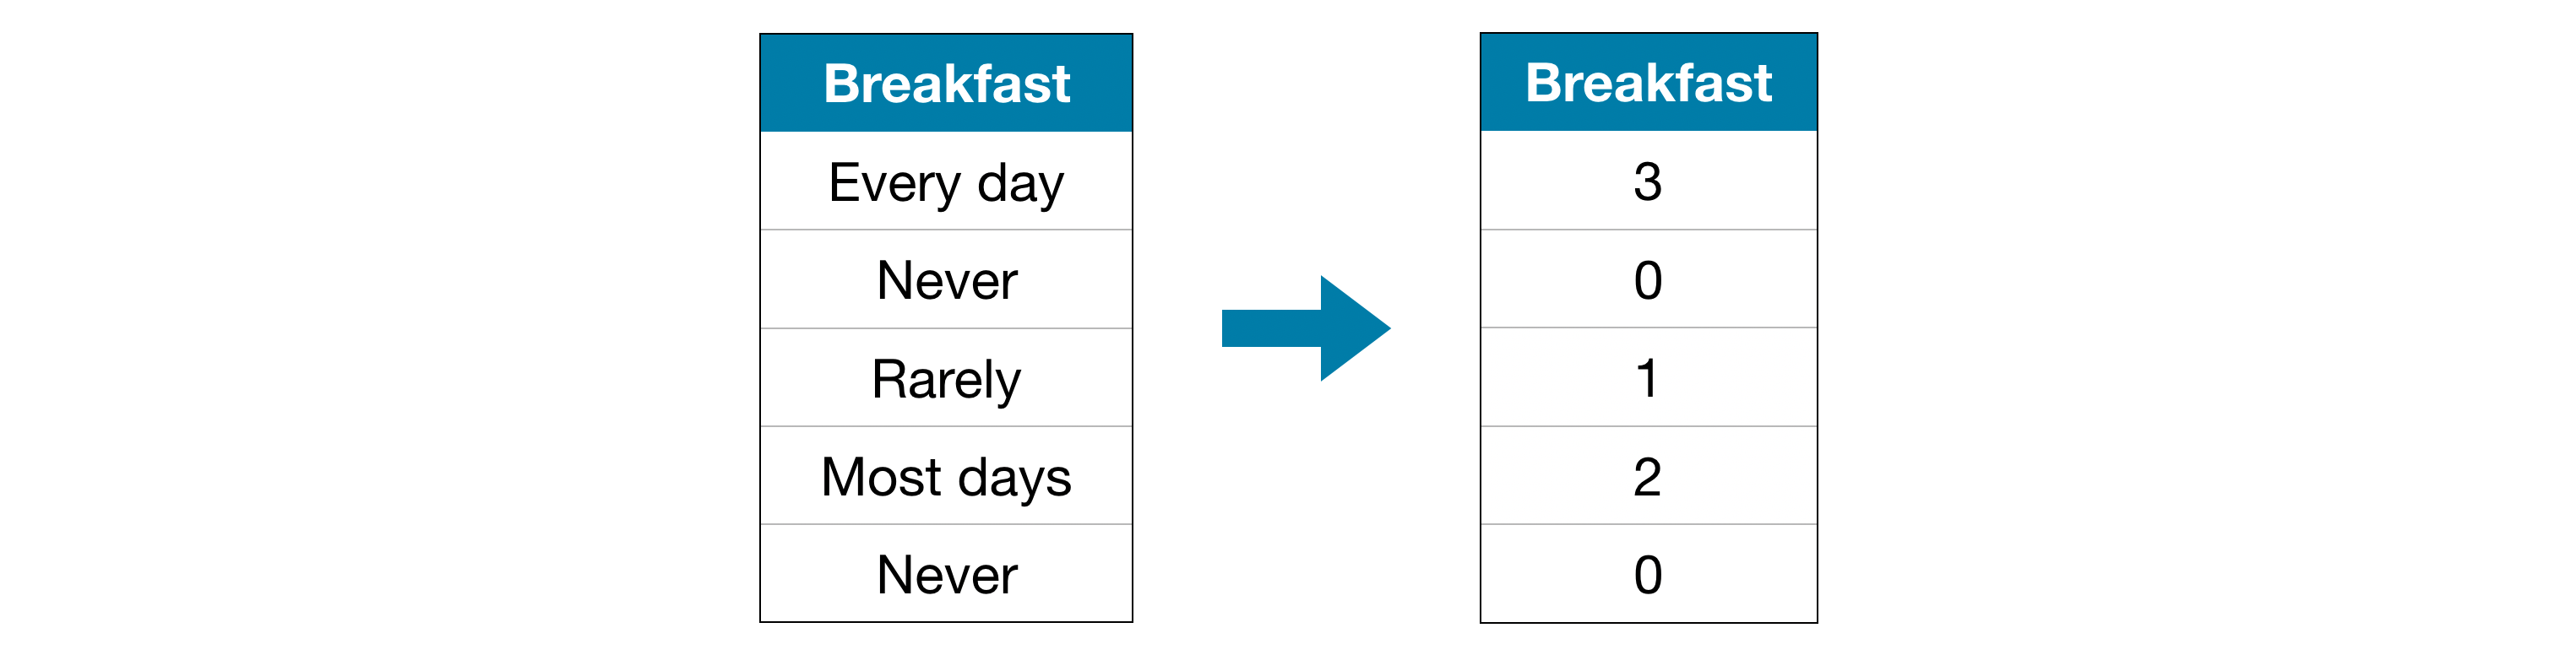

This approach assumes an ordering of the categories: "Never" (0) < "Rarely" (1) < "Most days" (2) < "Every day" (3).

This assumption makes sense in this example, because there is an indisputable ranking to the categories. Not all categorical variables have a clear ordering in the values, but we refer to those that do as ordinal variables. For tree-based models (like decision trees and random forests), you can expect ordinal encoding to work well with ordinal variables.

##  One-Hot Encoding
**One-hot encoding** creates new columns indicating the presence (or absence) of each possible value in the original data. To understand this, we'll work through an example.

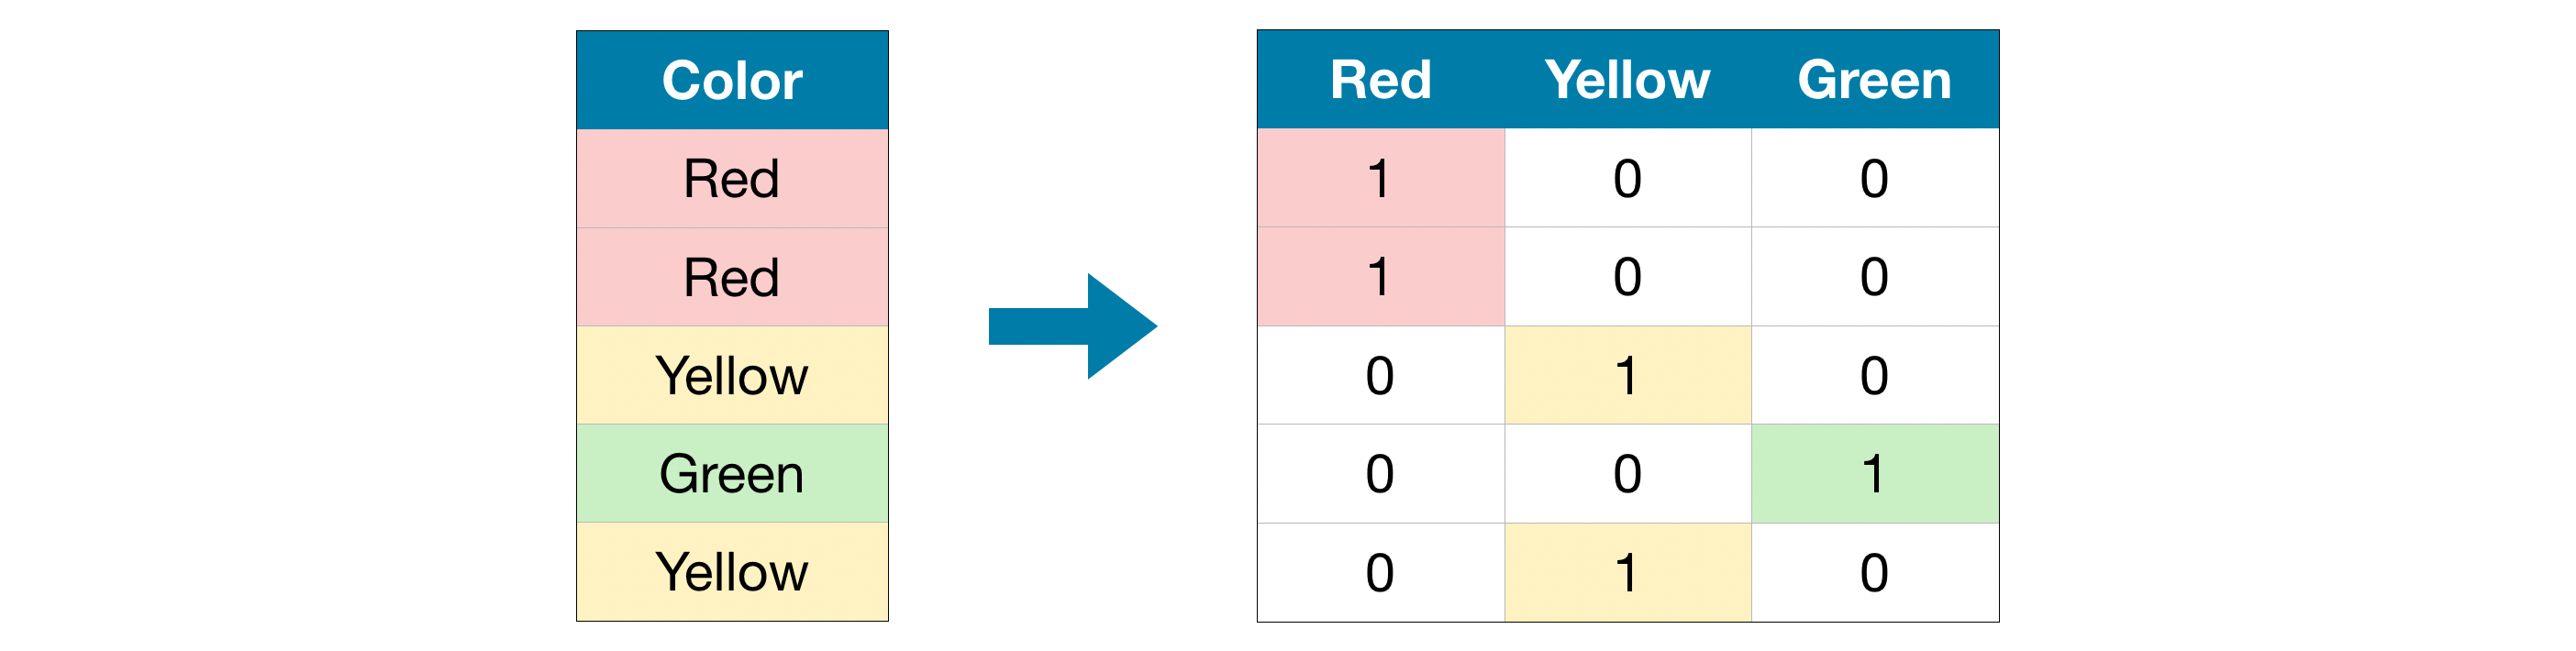

In the original dataset, "Color" is a categorical variable with three categories: "Red", "Yellow", and "Green". The corresponding one-hot encoding contains one column for each possible value, and one row for each row in the original dataset. Wherever the original value was "Red", we put a 1 in the "Red" column; if the original value was "Yellow", we put a 1 in the "Yellow" column, and so on.

In contrast to ordinal encoding, one-hot encoding does not assume an ordering of the categories. Thus, you can expect this approach to work particularly well if there is no clear ordering in the categorical data (e.g., "Red" is neither more nor less than "Yellow"). We refer to categorical variables without an intrinsic ranking as **nominal variables**.

One-hot encoding generally does not perform well if the categorical variable takes on a large number of values (i.e., you generally won't use it for variables taking more than 15 different values).



Biến phân loại là biến chỉ có 1 số lượng nhất định giá trị trong biến đó 

Ví dụ: Biến breakfast gồm 4 giá trị là 'Rarely','Never','Most days','Everyday'

Việc tồn tại những biến phân loại mang giá trị string như vậy sẽ gây lỗi cho mô hình ML => có 3 cách giải quyết 
1. Xóa biến đấy (trong trường hợp nó không quan trọng)
2. Ordinary Decoding (Chuyển chúng thành giá trị số): chỉ khi các giá trị trong biến có sự phân chia cao thấp
3. One-hot decoding : Thêm các cột mà mỗi giá trị là các giá trị trong biến đó, điền 1 nếu hàng đó có, 0 nếu không. Hoạt động tốt nếu biến không có sự phân hóa về thứ tự

# Example

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
data = pd.read_csv("./input/melb_data.csv")

#Separate targer from predictors 
y = data.Price 
X = data.drop(['Price'],axis=1)

#Divide data into training and validation subsets 
X_train_full,X_valid_full,y_train,y_valid = train_test_split(X,y,train_size=0.8,test_size=0.2,random_state=0)

#Drop missing values columns 
cols_with_missing = [col for col in X_train_full.columns if X_train_full[col].isnull().any()]
X_train_full.drop(cols_with_missing,axis=1,inplace=True)
X_valid_full.drop(cols_with_missing,axis=1,inplace=True)

# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
low_cardinality_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and 
                        X_train_full[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = low_cardinality_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()

In [20]:
X_train.head()

,Type,Method,Regionname,Rooms,Distance,Postcode,Bedroom2,Bathroom,Landsize,Lattitude,Longtitude,Propertycount
12167,u,S,Southern Metropolitan,1,5.0,3182.0,1.0,1.0,0.0,-37.85984,144.9867,13240.0
6524,h,SA,Western Metropolitan,2,8.0,3016.0,2.0,2.0,193.0,-37.85800,144.9005,6380.0
8413,h,S,Western Metropolitan,3,12.6,3020.0,3.0,1.0,555.0,-37.79880,144.8220,3755.0
2919,u,SP,Northern Metropolitan,3,13.0,3046.0,3.0,1.0,265.0,-37.70830,144.9158,8870.0
6043,h,S,Western Metropolitan,3,13.3,3020.0,3.0,1.0,673.0,-37.76230,144.8272,4217.0


## Find categorical variables
We do this by checking the data type (or **dtype**) of each column. The `object` dtype indicates a column has text (there are other things it could theoretically be, but that's unimportant for our purposes).

In [12]:
#Check dtypes of all variables
checked = ( X_train.dtypes == 'object')
checked

Type              True
Method            True
Regionname        True
Rooms            False
Distance         False
Postcode         False
Bedroom2         False
Bathroom         False
Landsize         False
Lattitude        False
Longtitude       False
Propertycount    False
dtype: bool

In [17]:
# Get list of categorical variables
object_col = list(checked[checked].index)

print("Categorical variables:",object_col)

Categorical variables: ['Type', 'Method', 'Regionname']


## Define function to measure quality of each approach

function | score_dataset()
|------|-------|
parameters|xt (x_train), xv(x_valid), yt(y_train), tv (y_valid)
model| RandomForestRegressor
return|mean absolute error (MAE)

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

def score_dataset(xt,xv,yt,yv):
    model = RandomForestRegressor(n_estimators=100,random_state=0)
    model.fit(xt,yt) 
    pred = model.predict(xv)
    mae = mean_absolute_error(yv,pred)
    
    return mae

In [28]:
scores = []

## Approach 1 (Drop Categorical Variables)
Drop `opject` columns by using `select_dtypes()` methods

In [29]:
approach1_x_train = X_train.select_dtypes(exclude='object')
approach1_x_valid = X_valid.select_dtypes(exclude='object')

ap1 = score_dataset(approach1_x_train,approach1_x_valid,y_train,y_valid)
scores.append(ap1)

print("MAE from Approach 1 (Drop Categorical Variables):",ap1)

MAE from Approach 1 (Drop Categorical Variables): 175703.48185157913


## Approach 2 (Ordinal Encoding)

Scikit-learn has a `OrdinalEncoder` class that can be used to get ordinal encodings. 

In [30]:
from sklearn.preprocessing import OrdinalEncoder

approach2_x_train = X_train.copy()
approach2_x_valid = X_valid.copy()

my_ordinal_encoder = OrdinalEncoder()
approach2_x_train[object_col] = my_ordinal_encoder.fit_transform(X_train[object_col])
approach2_x_valid[object_col] = my_ordinal_encoder.transform(X_valid[object_col])


ap2 = score_dataset(approach2_x_train,approach2_x_valid,y_train,y_valid)
scores.append(ap2)

print("MAE from Approach 2 (Ordinal Encoding):", ap2)


MAE from Approach 2 (Ordinal Encoding): 165936.40548390493


In the code cell above, for each column, we randomly assign each unique value to a different integer. This is a common approach that is simpler than providing custom labels; however, we can expect an additional boost in performance if we provide better-informed labels for all ordinal variables.

## Approach 3 (One-Hot Encoding)


We use the `OneHotEncoder` class from scikit-learn to get one-hot encodings. There are a number of parameters that can be used to customize its behavior.

+ We set `handle_unknown='ignore'` to **avoid errors** when the **validation data contains classes that aren't represented in the training data**

+ setting `sparse=False` ensures that the **encoded columns are returned as a numpy array** (instead of a sparse matrix).

In [34]:
from sklearn.preprocessing import OneHotEncoder

# Apply one-hot encoder to each colum with categorical data
my_one_hot_decoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(my_one_hot_decoder.fit_transform(X_train[object_col]))
OH_cols_valid = pd.DataFrame(my_one_hot_decoder.transform(X_valid[object_col]))

# One-Hot Decoder removed index, put it back
OH_cols_train.index = X_train.index
OH_cols_valid.index = X_valid.index

# Remove categorical columns (with replace with one-hot encoding)
numerical_cols_train = X_train.drop(object_col,axis=1)
numerical_cols_valid = X_valid.drop(object_col,axis=1)

c:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


At this time, we had `OH_col_trains` that contain only **new numeric values** (that **encode from old categorical variables**) and `numerical_cols_train` that have the **original numerical variables** in the data.

-> Merge them both and we will have the `approach3_x_train` (Using `pd.concat()`)

In [40]:
# Add one-hot encoded columns to numerical features
approach3_x_train = pd.concat([numerical_cols_train, OH_cols_train], axis=1)
approach3_x_valid = pd.concat([numerical_cols_valid, OH_cols_valid], axis=1)

# Ensure all columns have string type
approach3_x_train.columns = approach3_x_train.columns.astype(str)
approach3_x_valid.columns = approach3_x_valid.columns.astype(str)


ap3 = score_dataset(approach3_x_train,approach3_x_valid,y_train,y_valid)
scores.append(ap3)

print("MAE from Approach 3 (One-Hot Encoding):",ap3) 


MAE from Approach 3 (One-Hot Encoding): 166089.4893009678


## Evaluate

In [44]:
for i in range(len(scores)):
    print(f"Approach {i+1} MAE:\t{scores[i]}")

Approach 1 MAE:	175703.48185157913
Approach 2 MAE:	165936.40548390493
Approach 3 MAE:	166089.4893009678


Approach 1 performed worst, since it had the highest MAE score.

As for the other two approaches, since the returned MAE scores are so close in value, there doesn't appear to be any meaningful benefit to one over the other.

In general, one-hot encoding (**Approach 3**) will typically perform best, and dropping the categorical columns (**Approach 1)** typically performs worst, but it varies on a case-by-case basis.